# demo model

note here

In [1]:
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


/opt/anaconda3/envs/zpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import *
from HARK.utilities import plot_funcs

In [3]:
LifeCycle_dictionary = {
    "CRRA": 2.0,
    "Rfree": 1.04,
    "DiscFac": 0.98,
    "LivPrb": [0.99, 0.98, 0.97, 0.96, 0.95, 0.94, 0.93, 0.92, 0.91, 0.90],
    "PermGroFac": [1.01, 1.01, 1.01, 1.02, 1.00, 0.99, 0.5, 1.0, 1.0, 1.0],
    "T_cycle": 10,  # Our time varying parameters are a list with 10 elements
    "cycles": 1,  # Repeats once
}

LC_agent = PerfForesightConsumerType(**LifeCycle_dictionary)

In [4]:
LC_agent.solve()
DefaultType = IndShockConsumerType(cycles=0, vFuncBool=True)
DefaultType.solve()
DefaultType.unpack("cFunc")
myPolicy = DefaultType.cFunc[0]


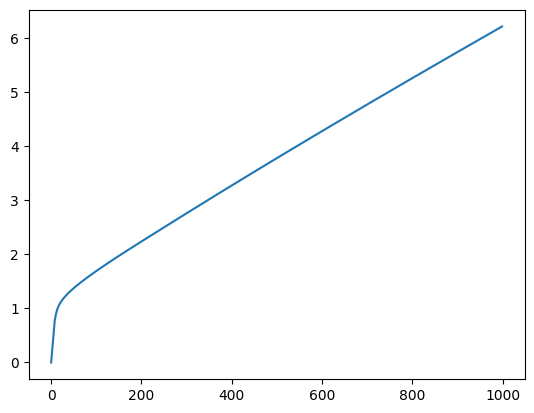

In [5]:
plt.plot([myPolicy(x) for x in np.linspace(0, 100, 1000)])

/opt/anaconda3/envs/zpy/lib/python3.12/site-packages/HARK/rewards.py:40: RuntimeWarning: divide by zero encountered in reciprocal
  return c ** (1.0 - rho) / (1.0 - rho)


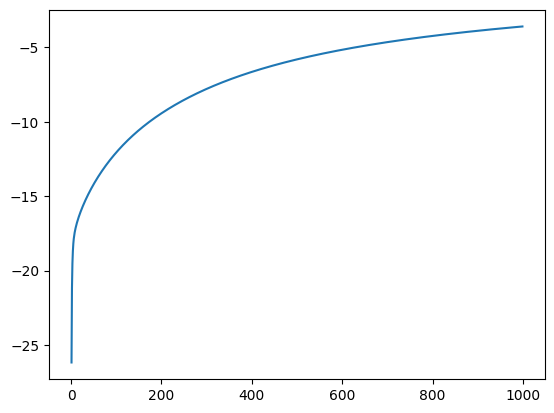

In [6]:
#pull the utility function out of the model
DefaultType.unpack('vFunc')
myUtility = DefaultType.vFunc[0]
plt.plot([myUtility(x) for x in np.linspace(0, 100, 1000)])

In [7]:
MONTE_CARLO_RUNS = 5
SIMULATION_TIMESTEPS = 100


In [8]:

def gamma_noise(shape = 2, scale = 2):
    return np.random.gamma(shape=shape, scale=scale)


(array([9.910e+02, 2.531e+03, 3.714e+03, 4.468e+03, 5.006e+03, 5.231e+03,
        5.396e+03, 5.431e+03, 5.203e+03, 5.024e+03, 4.848e+03, 4.677e+03,
        4.367e+03, 3.955e+03, 3.638e+03, 3.480e+03, 3.091e+03, 2.819e+03,
        2.621e+03, 2.375e+03, 2.137e+03, 2.022e+03, 1.813e+03, 1.655e+03,
        1.526e+03, 1.281e+03, 1.135e+03, 1.042e+03, 9.520e+02, 8.150e+02,
        7.200e+02, 7.200e+02, 5.670e+02, 5.820e+02, 4.640e+02, 4.210e+02,
        3.820e+02, 3.520e+02, 2.920e+02, 2.510e+02, 2.150e+02, 2.100e+02,
        1.820e+02, 1.580e+02, 1.630e+02, 1.350e+02, 1.090e+02, 1.080e+02,
        8.000e+01, 7.600e+01, 7.500e+01, 4.800e+01, 6.600e+01, 4.400e+01,
        4.800e+01, 4.100e+01, 2.500e+01, 2.600e+01, 2.100e+01, 1.700e+01,
        1.600e+01, 1.700e+01, 1.700e+01, 8.000e+00, 1.900e+01, 8.000e+00,
        9.000e+00, 7.000e+00, 8.000e+00, 6.000e+00, 6.000e+00, 1.000e+01,
        1.000e+00, 4.000e+00, 4.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00, 0.000e+0

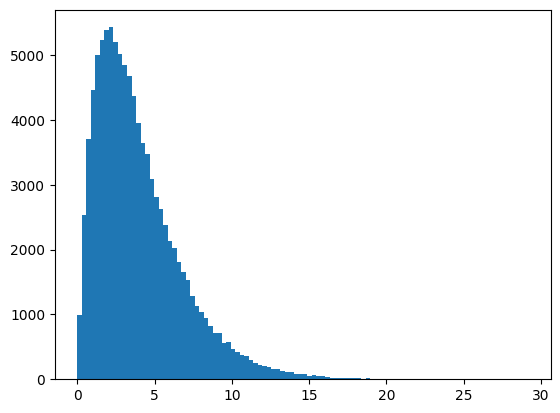

In [9]:
plt.hist([gamma_noise() for _ in range(100000)], bins=100)

In [10]:


sys_params = {
    'R': [.75, .5, .25]
}

genesis_states = {
    'x': 10
}


In [11]:
def act(params, 
                substep, 
                state_history, 
                prev_state):
    
    x = prev_state['x']
    #val = params['value'](x) 
    #draw a random number from a uniform distributi
    y = myPolicy(x)

    return {'action':y}

def noise(params, 
                substep, 
                state_history, 
                prev_state):
    rng = gamma_noise()

    return {'theta':rng}



In [12]:

def update(params, 
                substep, 
                state_history, 
                prev_state, 
                policy_input):
    x = params['R']*(prev_state['x']-policy_input['action']) + policy_input['theta']
    return ('x', x)

partial_state_update_blocks = [
    {
        'policies': {'act': act,
                     'noise': noise
        },
        'variables': {
            'update': update
        }
    }
]

sim_config = {
    'N': MONTE_CARLO_RUNS,
    'T': range(SIMULATION_TIMESTEPS),
    'M': sys_params
}

In [13]:
sim_params = config_sim(sim_config)

exp = Experiment()
exp.append_configs(
    sim_configs=sim_params,
    initial_state=genesis_states,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(context=exec_mode.local_mode)

simulation = Executor(exec_context=local_mode_ctx,
                      configs=exp.configs)
raw_system_events, tensor_field, sessions = simulation.execute()


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 100, 1, 15, 1)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (100, 1, 15, 1)


Initializing configurations: 100%|██████████| 15/15 [00:00<00:00, 1004.16it/s]

Execution Method: parallelize_simulations



Flattening results: 100%|██████████| 15/15 [00:00<00:00, 797.62it/s]

Total execution time: 0.50s


In [14]:
df = pd.DataFrame(raw_system_events)

In [15]:
df

,x,simulation,subset,run,substep,timestep
0,10.000000,0,0,1,0,0
1,14.983420,0,0,1,1,1
2,16.198102,0,0,1,1,2
3,12.290070,0,0,1,1,3
4,16.821458,0,0,1,1,4
...,...,...,...,...,...,...
1510,4.557258,0,2,5,1,96
1511,10.425852,0,2,5,1,97
1512,4.134708,0,2,5,1,98
1513,4.638162,0,2,5,1,99


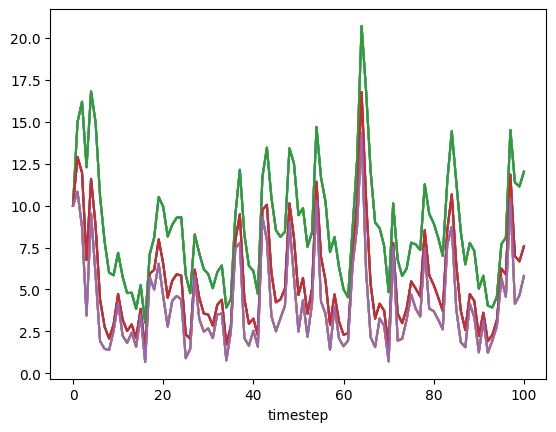

In [16]:
for run in df['run'].unique():
    for ss in df['subset'].unique():
        df[(df['run'] == run) & (df['subset'] == ss)].set_index('timestep')['x'].plot()


In [17]:
df["value"] = df["x"].apply(lambda x: myUtility(x))

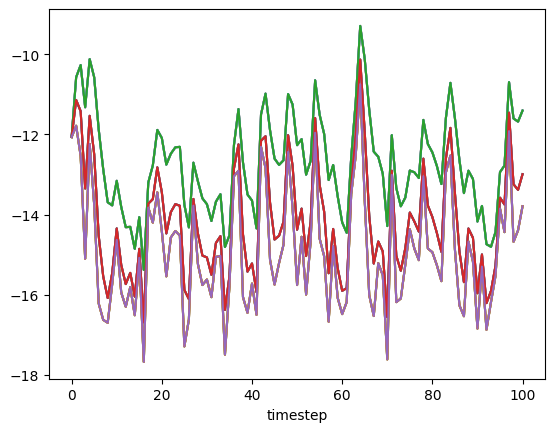

In [18]:
for run in df['run'].unique():
    for ss in df['subset'].unique():
        df[(df['run'] == run) & (df['subset'] == ss)].set_index('timestep')['value'].plot()
